In [1]:
import pandas as pd
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import joblib
import time

from sklearn.linear_model import LogisticRegression
from keras.models import load_model
from sklearn.preprocessing import OneHotEncoder
from keras.callbacks import EarlyStopping
from tensorflow import keras
from keras.layers import LSTM,Dense,Dropout,BatchNormalization,LayerNormalization, InputLayer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

In [2]:
# read in the processed data
All_Games = pd.read_csv("All_Matches.csv")

In [3]:
# one hot encode the categorical columns

encoder = OneHotEncoder()
encoder_df = pd.DataFrame(encoder.fit_transform(All_Games[["Rank","Top_Current_Champ", "Jg_Current_Champ", "Mid_Current_Champ", "Bot_Current_Champ", "Sup_Current_Champ","Top_Enemy_Champ", "Jg_Enemy_Champ", "Mid_Enemy_Champ", "Bot_Enemy_Champ", "Sup_Enemy_Champ"]]).toarray())

In [4]:
encoder_df

,0,1,2,3,4,5,6,7,8,9,...,1236,1237,1238,1239,1240,1241,1242,1243,1244,1245
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14996,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14997,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14998,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
# drop the categorical columns and join the one hot encoded version

All_Games = All_Games.drop(["Rank","Top_Current_Champ", "Jg_Current_Champ", "Mid_Current_Champ", "Bot_Current_Champ", "Sup_Current_Champ","Top_Enemy_Champ", "Jg_Enemy_Champ", "Mid_Enemy_Champ", "Bot_Enemy_Champ", "Sup_Enemy_Champ"],axis=1)
All_Games = pd.DataFrame(np.hstack([All_Games, encoder_df]))

In [6]:
All_Games

,0,1,2,3,4,5,6,7,8,9,...,1373,1374,1375,1376,1377,1378,1379,1380,1381,1382
0,1.0,0.0,18.0,5.0,16.0,4.0,2.0,3.0,9.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,20.0,4.0,14.0,6.0,1.0,3.0,13.0,8.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,1.0,20.0,2.0,13.0,7.0,1.0,2.0,7.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,19.0,5.0,16.0,4.0,0.0,3.0,16.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,19.0,11.0,16.0,4.0,1.0,4.0,18.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14995,1.0,1.0,18.0,2.0,9.0,11.0,1.0,3.0,6.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14996,0.0,1.0,19.0,11.0,13.0,7.0,2.0,5.0,11.0,6.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14997,1.0,0.0,13.0,5.0,10.0,10.0,0.0,1.0,20.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14998,1.0,0.0,18.0,1.0,10.0,10.0,0.0,1.0,20.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
#All_Games = shuffle(All_Games)

In [8]:
X = All_Games.iloc[:,1:]
y = All_Games.iloc[:,0]

In [9]:
# train_ratio = 0.80
# test_ratio = 0.10
# validation_ratio = 0.10

# X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=test_ratio)

# X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=validation_ratio/(train_ratio+test_ratio))

In [10]:
X_train, X_valid, Y_train, Y_valid = train_test_split(X, y, test_size=.20, shuffle=True,random_state=5)

In [11]:
#split the 80-20 to 80-10-10

SplitX = X_valid
SplitY = Y_valid

X_valid = SplitX.iloc[:1500]
Y_valid = SplitY.iloc[:1500]

X_test = SplitX.iloc[1500:]
Y_test = SplitY.iloc[1500:]

In [12]:
#scale the data using minmax

sc = MinMaxScaler()

X_train = sc.fit_transform(X_train)
X_valid = sc.transform(X_valid)
X_test = sc.transform(X_test)

In [13]:
#create the model

model_one_hot = keras.Sequential() 

model_one_hot.add(InputLayer(input_shape=X_train.shape[1]))
model_one_hot.add(Dense(128, activation='relu'))  

model_one_hot.add(Dense(1, activation='sigmoid')) 

model_one_hot.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), metrics=['acc'])

model_one_hot.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               177024    
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 177,153
Trainable params: 177,153
Non-trainable params: 0
_________________________________________________________________


In [14]:
# early stopping

es = EarlyStopping(monitor='val_acc', mode='max', patience=10, restore_best_weights=True)

In [15]:
# fit with early stopping

with tf.device('/GPU:0'):
    fit_model_one_hot = model_one_hot.fit(X_train, Y_train, validation_data=(X_valid,Y_valid), epochs=250, callbacks=es)

Epoch 1/250
375/375 [==============================] - 2s 3ms/step - loss: 0.6961 - acc: 0.4946 - val_loss: 0.6942 - val_acc: 0.4967
Epoch 2/250
375/375 [==============================] - 1s 2ms/step - loss: 0.6930 - acc: 0.5093 - val_loss: 0.6924 - val_acc: 0.5053
Epoch 3/250
375/375 [==============================] - 1s 2ms/step - loss: 0.6910 - acc: 0.5227 - val_loss: 0.6918 - val_acc: 0.5313
Epoch 4/250
375/375 [==============================] - 1s 2ms/step - loss: 0.6891 - acc: 0.5347 - val_loss: 0.6903 - val_acc: 0.5160
Epoch 5/250
375/375 [==============================] - 1s 3ms/step - loss: 0.6875 - acc: 0.5438 - val_loss: 0.6896 - val_acc: 0.5253
Epoch 6/250
375/375 [==============================] - 1s 2ms/step - loss: 0.6857 - acc: 0.5502 - val_loss: 0.6888 - val_acc: 0.5213
Epoch 7/250
375/375 [==============================] - 1s 2ms/step - loss: 0.6844 - acc: 0.5601 - val_loss: 0.6887 - val_acc: 0.5420
Epoch 8/250
375/375 [==============================] - 1s 2ms/step - 

In [16]:
# print loss and score on testing

score = model_one_hot.evaluate(X_test, Y_test,verbose=0)
#score = model_one_hot.evaluate(X_valid, Y_valid,verbose=0)
print(f'Test loss: {score[0]} / Test accuracy: {score[1]}')

Test loss: 0.6902012825012207 / Test accuracy: 0.5320000052452087


In [17]:
# save the model

model_one_hot.save("KerasModel.h5")

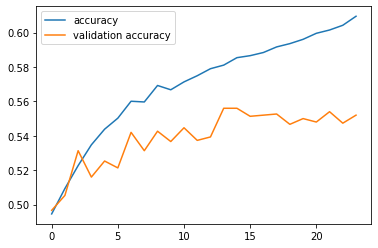

In [18]:
# plit graphs

plt.plot(fit_model_one_hot.history['acc'])
plt.plot(fit_model_one_hot.history['val_acc'])
plt.legend(['accuracy','validation accuracy'])

In [19]:
# save the scaler and encoder to be used to for predictions later on the website

joblib.dump(sc, 'MinMaxScaler.gz')
joblib.dump(encoder,'OneHotEncoder.joblib')

['OneHotEncoder.joblib']

In [20]:
# load the scaler and encdoer and transform the prediction dataframe/csv
# modified in the website file

def ProcessLiveData(data):
    min_max_scaler = joblib.load('MinMaxScaler.gz')
    one_hot_encoder = joblib.load('OneHotEncoder.joblib')
    encoder_lobby = pd.DataFrame(one_hot_encoder.transform(data[["Rank","Top_Current_Champ", "Jg_Current_Champ", "Mid_Current_Champ", "Bot_Current_Champ", "Sup_Current_Champ","Top_Enemy_Champ", "Jg_Enemy_Champ", "Mid_Enemy_Champ", "Bot_Enemy_Champ", "Sup_Enemy_Champ"]]).toarray())
    data = data.join(encoder_lobby)
    data = data.drop(["Rank","Top_Current_Champ", "Jg_Current_Champ", "Mid_Current_Champ", "Bot_Current_Champ", "Sup_Current_Champ","Top_Enemy_Champ", "Jg_Enemy_Champ", "Mid_Enemy_Champ", "Bot_Enemy_Champ", "Sup_Enemy_Champ"],axis=1)
    data["Side"] = data["Side"].astype('category')
    data["Side"] = data["Side"].cat.codes
    data = min_max_scaler.transform(data)
    return data

In [21]:
# load the model call the process data function and then use that to output a prediction

def Predict():
    model = load_model('KerasModel.h5')
    lobby =  pd.read_csv("lobby.csv")
    NewPredict = ProcessLiveData(lobby)
    return model.predict(NewPredict)[0,0]

In [22]:
# holds the prediction

prediction = Predict()

c:\Users\Tigran\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [23]:
# output the prediction

prediction

0.86445713

In [ ]:
# train multiple times

accuracies = []

for i in range(15):
    
    model_one_hot = keras.Sequential() 
    model_one_hot.add(InputLayer(input_shape=X_train.shape[1]))
    model_one_hot.add(Dense(128, activation='relu'))  
    model_one_hot.add(Dense(1, activation='sigmoid')) 
    model_one_hot.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.SGD(learning_rate=0.01), metrics=['acc'])

    fit_model_one_hot = model_one_hot.fit(X_train, Y_train, validation_data=(X_valid,Y_valid), epochs=250, callbacks=es)
    score = model_one_hot.evaluate(X_test, Y_test,verbose=0)
    accuracies.append(score[1])

In [ ]:
# calculate the mean and standard deviation

accuracies_percent = [element * 100 for element in accuracies]

print("The original list : " + str(accuracies_percent))
print("mean : ",sum(accuracies_percent) / len(accuracies_percent))
# Standard deviation of list
# Using sum() + list comprehension
mean = sum(accuracies_percent) / len(accuracies_percent)
variance = sum([((x - mean) ** 2) for x in accuracies_percent]) / len(accuracies_percent)
res = variance ** 0.5
  
# Printing result
print("Standard deviation of sample is : " + str(res))